## Best Classifier for Fashion-MNIST Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay
import seaborn as sns

from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical   

import csv

import warnings
warnings.filterwarnings('ignore')

seed = 1234
np.random.seed(seed) 

2022-12-18 12:03:54.072985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Clean Data

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

x_tr = X_train.astype(int)
x_te = X_test.astype(int)

y_tr = y_train.astype(int)
y_te = y_test.astype(int)

X_fashion = np.concatenate([x_tr, x_te])
y_fashion = np.concatenate([y_tr, y_te])

X_tr, X_te, y_tr, y_te = train_test_split(X_fashion, y_fashion, test_size=0.20, random_state=seed, shuffle=True)

print(f"X_tr shape: {X_tr.shape}")
print(f"X_te shape: {X_te.shape}")

print(f"y_tr shape: {y_tr.shape}")
print(f"y_te.shape: {y_te.shape}")

X_tr shape: (56000, 28, 28)
X_te shape: (14000, 28, 28)
y_tr shape: (56000,)
y_te.shape: (14000,)


### Glimpse of Dataset

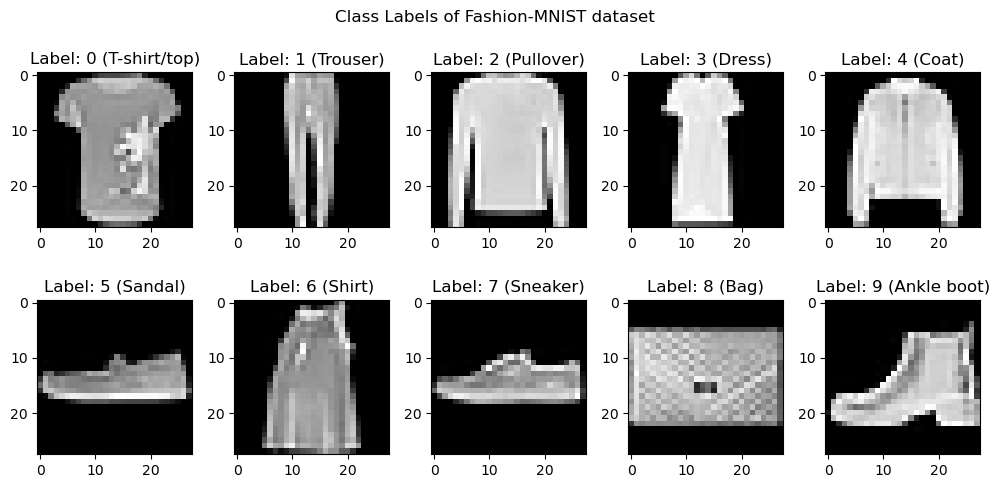

In [3]:
# Real Label

def find(arr, elem):
    for index, item in enumerate(arr):
        if item == elem:
            return index

TrueLabels = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 
              5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray' 
figure, axes = plt.subplots(2, 5, figsize=(10, 5))

i = 0
for x in range(2): 
    for y in range(5):
        index = find(y_tr, i)
        axes[x, y].imshow(X_tr[index]) 
        axes[x, y].set_title(f'Label: {i} ({TrueLabels[i]})') 
        i+= 1

plt.suptitle("Class Labels of Fashion-MNIST dataset")
plt.tight_layout() 

### Standardize and Set Up Validation Set

In [4]:
X_tr = np.reshape(X_tr, (56000,784))
X_te = np.reshape(X_te, (14000,784))

y_tr = y_tr.flatten()
y_te = y_te.flatten()

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

X_val = X_tr[42000:]
y_val = y_tr[42000:]

X_tr = X_tr[:42000]
y_tr = y_tr[:42000]

### Make Confusion Matrix

In [5]:
def cm(y_pred, title):
    fig, ax = plt.subplots(figsize=(7, 5))

    sklearn_cm_eu = confusion_matrix(y_te, y_pred)
    sns.heatmap(sklearn_cm_eu, annot=True, ax=ax, fmt='g')

    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")

    ax.set_title(f"Confusion Matrix of Fashion-MNIST using {title}")
    return plt

### Line Graph to Compare Results

In [6]:
def line_graph(x, y_train, y_val, title, x_label, y_label, color='blue', loc='upper right'):
    fig, axes = plt.subplots()

    axes.semilogx(x, y_train, linestyle='-', marker='x', color=color, label='Train')
    axes.semilogx(x, y_val, linestyle='--', marker='x', color=color, label='Validation')

    axes.legend(loc=loc)
    axes.set_xlabel(x_label, fontsize=14)
    axes.set_ylabel(y_label, fontsize=14)
    axes.set_title(title)
    return plt

### Record Results

In [7]:
def write_results(file, settings, headers):   
    with open(file, "a", newline='\n') as f:
        writer = csv.DictWriter(f, fieldnames=headers)
        writer.writerow(settings)

def view_results(file):
    df = pd.read_csv(file)
    return df

### Show Incorrect Predictions

In [8]:
def find_incorrect(predictions, true_label, predict_label):
    
    results = []
    length = len(y_te)
    for i in range(length):
        if y_te[i] == true_label and predictions[i] == predict_label:
            results.append(i)
        if len(results) == 10:
            return results

def print_incorrect(predictions, true_label, predict_label):
    
    indices = find_incorrect(predictions, true_label, predict_label)
    
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray' 
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    
    for i in range(10):
        axes[i//5, i%5].imshow(X_te[indices[i]].reshape(28, 28))
        
    fig.suptitle(f"Images of {TrueLabels[true_label]} But Predicted As {TrueLabels[predict_label]}")
    plt.tight_layout()
    return plt

### Nearest Centroid Classifier

In [8]:
nc = NearestCentroid().fit(X_tr, y_tr)
train_predict = nc.predict(X_tr)
val_predict = nc.predict(X_te)
test_predict = nc.predict(X_val)

results = {"Train Accuracy": [0], "Validation Accuracy": [0], "Test Accuracy": [0]}

results["Train Accuracy"][0] = accuracy_score(y_tr, train_predict)
results["Validation Accuracy"][0] = accuracy_score(y_val, val_predict)
results["Test Accuracy"][0] = accuracy_score(y_te, test_predict)

df_nc = pd.DataFrame(results)

df_nc

,Train Accuracy,Validation Accuracy,Test Accuracy
0,0.681024,0.098714,0.101071


In [9]:
df_nc.to_csv('./results/nc.csv', index=False)

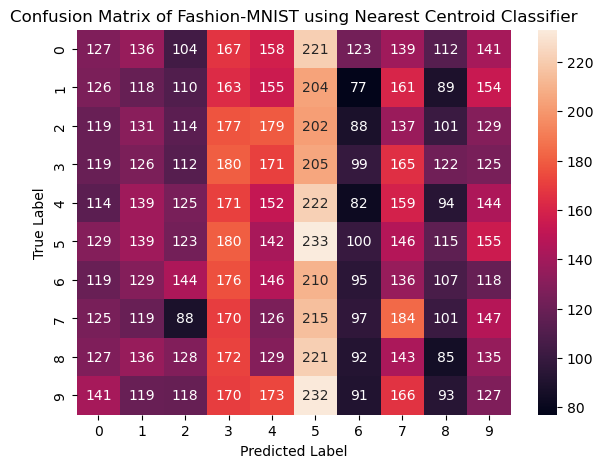

In [10]:
cm_knn = cm(test_predict, "Nearest Centroid Classifier")
cm_knn.show()

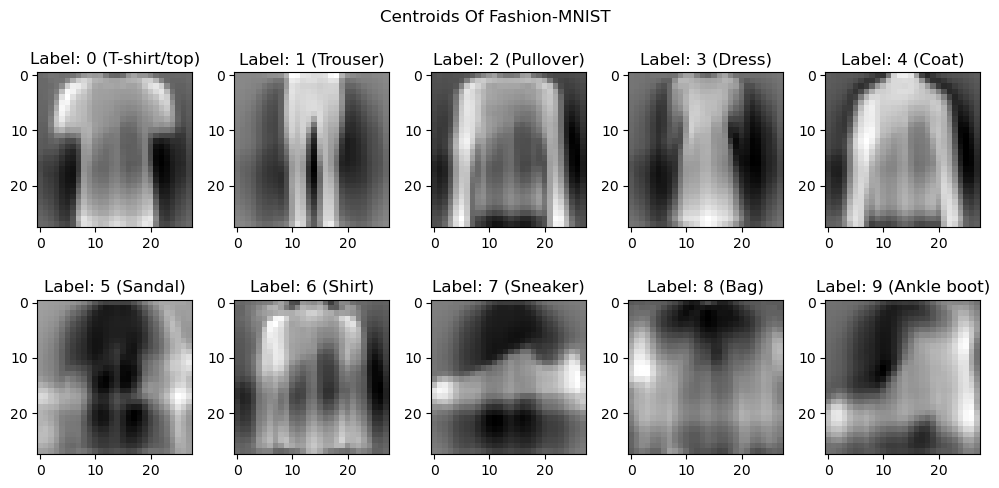

In [11]:
def plot_centroids(centroids):
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    
    for i in range(10):
        axes[i//5, i%5].imshow(centroids[i].reshape(28, 28))
        axes[i//5, i%5].set_title(f'Label: {i} ({TrueLabels[i]})')
    fig.suptitle("Centroids Of Fashion-MNIST")
    plt.tight_layout()
    plt.show()

plot_centroids(nc.centroids_)

### KNN Classifier

In [12]:
def knnTrain(distance):

    HEADERS = ["K value", "Train Accuracy", "Validation Accuracy"]
    k_vals = [2, 5, 10, 15, 20, 30, 50]
    
    accuracies_train = np.zeros(len(k_vals))
    accuracies_val = np.zeros(len(k_vals))
    accuracies_test = np.zeros(len(k_vals))
    y_predictions = []
    
    for i, k in enumerate(k_vals):
        knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
        knn.fit(X_tr, y_tr)
        y_pred_train, y_pred_val, y_pred_test = knn.predict(X_tr), knn.predict(X_val), knn.predict(X_te)
        accuracies_train[i] = accuracy_score(y_tr, y_pred_train)
        accuracies_val[i] = accuracy_score(y_val, y_pred_val)
        accuracies_test[i] = accuracy_score(y_te, y_pred_test)
        y_predictions.append(y_pred_test)
        print(distance, k, accuracies_train[i], accuracies_val[i],accuracies_test[i])
    
    return accuracies_train, accuracies_val, accuracies_test, y_predictions

In [13]:
## predicting using 
k_vals = [2, 5, 10, 15, 20, 30, 50]
acc_train_eu, acc_val_eu, acc_test_eu, y_pred_eu = knnTrain('euclidean')

df_eu = pd.DataFrame({"K Value": k_vals, "Train Accuracy": acc_train_eu, 
                   "Validation Accuracy": acc_val_eu})
df_eu.style.set_caption("KNN Accuracy Using Euclidean Distance")

euclidean 2 0.928 0.8375 0.8433571428571428
euclidean 5 0.8955714285714286 0.8515 0.8499285714285715
euclidean 10 0.8735238095238095 0.8488571428571429 0.8487857142857143
euclidean 15 0.8630238095238095 0.8447857142857143 0.8443571428571428
euclidean 20 0.854904761904762 0.8403571428571428 0.8406428571428571
euclidean 30 0.8453095238095238 0.8325714285714285 0.8375
euclidean 50 0.8334047619047619 0.8247857142857142 0.8275


,K Value,Train Accuracy,Validation Accuracy
0,2,0.928000,0.837500
1,5,0.895571,0.851500
2,10,0.873524,0.848857
3,15,0.863024,0.844786
4,20,0.854905,0.840357
5,30,0.845310,0.832571
6,50,0.833405,0.824786


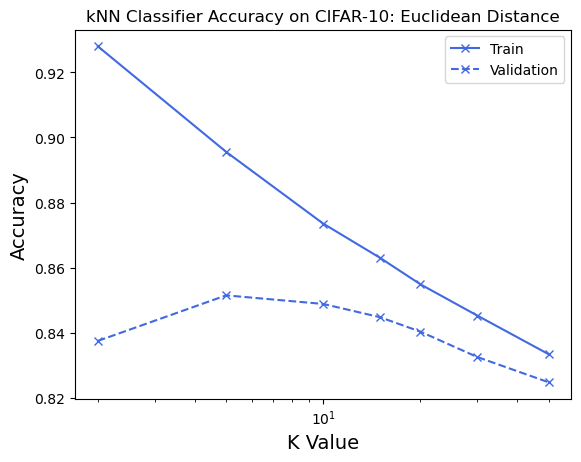

In [14]:
graph = line_graph(k_vals, acc_train_eu, acc_val_eu, 'kNN Classifier Accuracy on CIFAR-10: Euclidean Distance',
                  'K Value', 'Accuracy', 'royalblue')

graph.show()

In [15]:
df_eu["Test Accuracy"] = acc_test_eu
df_eu

,K Value,Train Accuracy,Validation Accuracy,Test Accuracy
0,2,0.928000,0.837500,0.843357
1,5,0.895571,0.851500,0.849929
2,10,0.873524,0.848857,0.848786
3,15,0.863024,0.844786,0.844357
4,20,0.854905,0.840357,0.840643
5,30,0.845310,0.832571,0.837500
6,50,0.833405,0.824786,0.827500


In [16]:
df_eu.to_csv('./results/knn_eu.csv', index=False)

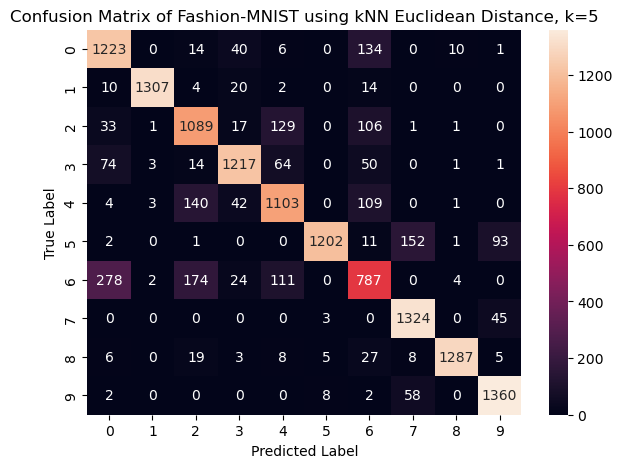

In [17]:
cm_knn = cm(y_pred_eu[1], "kNN Euclidean Distance, k=5")
cm_knn.show()

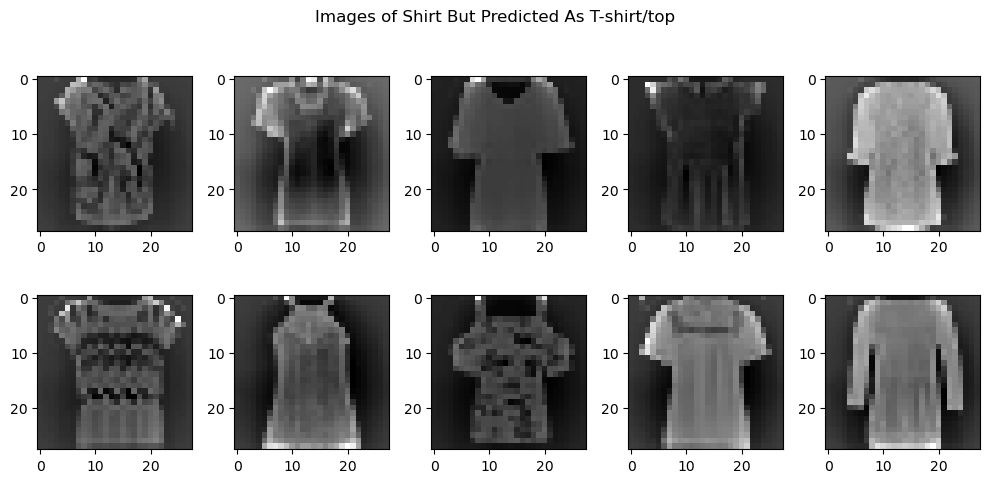

In [18]:
wrong_predictions = print_incorrect(y_pred_eu[1], 6, 0)
wrong_predictions.show()

### Logistic Classification

In [28]:
HEADERS = ["Solver", "Penalty", "Fit Intercept", "C", "Train Accuracy", "Validation Accuracy"]

DEFAULTS = {"Solver": "lbfgs", "Penalty": "l2", "Fit Intercept": "False", "C": 0.1, 
            "Train Accuracy": 0, "Validation Accuracy": 0}


In [20]:
def logistic_regression(default, solver='lbfgs', penalty='l2', intercept=True, strength=0.1):
    classifier = LogisticRegression(solver=solver, penalty=penalty, fit_intercept=intercept, 
                                    C=strength, random_state=seed).fit(X_tr, y_tr)
    predict_tr, predict_val = classifier.predict(X_tr), classifier.predict(X_val)
    
    default["Solver"] = solver
    default["Penalty"] = penalty
    default["Fit Intercept"] = intercept
    default["C"] = strength
    default["Train Accuracy"] = accuracy_score(y_tr, predict_tr)
    default["Validation Accuracy"] = accuracy_score(y_val, predict_val)
    
    print(f"Result: {default}")
    
    return default

In [21]:
## test for best solver and penalty
file_l = "./results/logistic.csv"

lbfgs_1 = logistic_regression(default=DEFAULTS.copy())
write_results(file_l, lbfgs_1, HEADERS)

lbfgs_2 = logistic_regression(default=DEFAULTS.copy(), penalty='none')
write_results(file_l, lbfgs_2, HEADERS)

liblinear_1 = logistic_regression(default=DEFAULTS.copy(), solver='liblinear', penalty='l1')
write_results(file_l, liblinear_1, HEADERS)

liblinear_2 = logistic_regression(default=DEFAULTS.copy(), solver='liblinear', penalty='l2')
write_results(file_l, liblinear_2, HEADERS)

newton_cg_1 = logistic_regression(default=DEFAULTS.copy(), solver='newton-cg', penalty='l2')
write_results(file_l, newton_cg_1, HEADERS)

newton_cg_2 = logistic_regression(default=DEFAULTS.copy(), solver='newton-cg', penalty='none')
write_results(file_l, newton_cg_2, HEADERS)


sag_1 = logistic_regression(default=DEFAULTS.copy(), solver='sag', penalty='l2')
write_results(file_l, sag_1, HEADERS)

sag_2 = logistic_regression(default=DEFAULTS.copy(), solver='sag', penalty='none')
write_results(file_l, sag_2, HEADERS)

saga_1 = logistic_regression(default=DEFAULTS.copy(), solver='saga', penalty='l1')
write_results(file_l, saga_1, HEADERS)

saga_2 = logistic_regression(default=DEFAULTS.copy(), solver='saga', penalty='l2')
write_results(file_l, saga_2, HEADERS)

saga_3 = logistic_regression(default=DEFAULTS.copy(), solver='saga', penalty='none')
write_results(file_l, saga_3, HEADERS)

Result: {'Solver': 'lbfgs', 'Penalty': 'l2', 'Fit Intercept': True, 'C': 0.1, 'Train Accuracy': 0.8806904761904762, 'Validation Accuracy': 0.853}
Result: {'Solver': 'lbfgs', 'Penalty': 'none', 'Fit Intercept': True, 'C': 0.1, 'Train Accuracy': 0.8803095238095238, 'Validation Accuracy': 0.8532142857142857}
Result: {'Solver': 'liblinear', 'Penalty': 'l1', 'Fit Intercept': True, 'C': 0.1, 'Train Accuracy': 0.866, 'Validation Accuracy': 0.8553571428571428}
Result: {'Solver': 'liblinear', 'Penalty': 'l2', 'Fit Intercept': True, 'C': 0.1, 'Train Accuracy': 0.8732619047619048, 'Validation Accuracy': 0.853}
Result: {'Solver': 'newton-cg', 'Penalty': 'l2', 'Fit Intercept': True, 'C': 0.1, 'Train Accuracy': 0.8872857142857142, 'Validation Accuracy': 0.8544285714285714}
Result: {'Solver': 'newton-cg', 'Penalty': 'none', 'Fit Intercept': True, 'C': 0.1, 'Train Accuracy': 0.8971190476190476, 'Validation Accuracy': 0.8315}
Result: {'Solver': 'sag', 'Penalty': 'l2', 'Fit Intercept': True, 'C': 0.1, '

In [22]:
df = view_results(file_l)
df

,Solver,Penalty,Fit Intercept,C,Train Accuracy,Validation Accuracy
0,lbfgs,l2,True,0.1,0.880690,0.853000
1,lbfgs,none,True,0.1,0.880310,0.853214
2,liblinear,l1,True,0.1,0.866000,0.855357
3,liblinear,l2,True,0.1,0.873262,0.853000
4,newton-cg,l2,True,0.1,0.887286,0.854429
5,newton-cg,none,True,0.1,0.897119,0.831500
6,sag,l2,True,0.1,0.869071,0.858857
7,sag,none,True,0.1,0.869238,0.858643
8,saga,l1,True,0.1,0.860143,0.856214
9,saga,l2,True,0.1,0.863381,0.857714


In [23]:
## testing regularization strength

strengths = [0.001, 0.01, 0.05, 0.1, 0.5, 1]

train_results = []
val_results = []

for s in strengths:
    result = logistic_regression(default=DEFAULTS.copy(), solver='sag', penalty='l2', strength=s)
    train_results.append(result['Train Accuracy'])
    val_results.append(result['Validation Accuracy'])
    write_results(file_l, result, HEADERS)

Result: {'Solver': 'sag', 'Penalty': 'l2', 'Fit Intercept': True, 'C': 0.001, 'Train Accuracy': 0.8550476190476191, 'Validation Accuracy': 0.8517142857142858}
Result: {'Solver': 'sag', 'Penalty': 'l2', 'Fit Intercept': True, 'C': 0.01, 'Train Accuracy': 0.8673571428571428, 'Validation Accuracy': 0.8587142857142858}
Result: {'Solver': 'sag', 'Penalty': 'l2', 'Fit Intercept': True, 'C': 0.05, 'Train Accuracy': 0.8688571428571429, 'Validation Accuracy': 0.8592142857142857}
Result: {'Solver': 'sag', 'Penalty': 'l2', 'Fit Intercept': True, 'C': 0.1, 'Train Accuracy': 0.8690714285714286, 'Validation Accuracy': 0.8588571428571429}
Result: {'Solver': 'sag', 'Penalty': 'l2', 'Fit Intercept': True, 'C': 0.5, 'Train Accuracy': 0.8692380952380953, 'Validation Accuracy': 0.8587142857142858}
Result: {'Solver': 'sag', 'Penalty': 'l2', 'Fit Intercept': True, 'C': 1, 'Train Accuracy': 0.8692142857142857, 'Validation Accuracy': 0.8585714285714285}


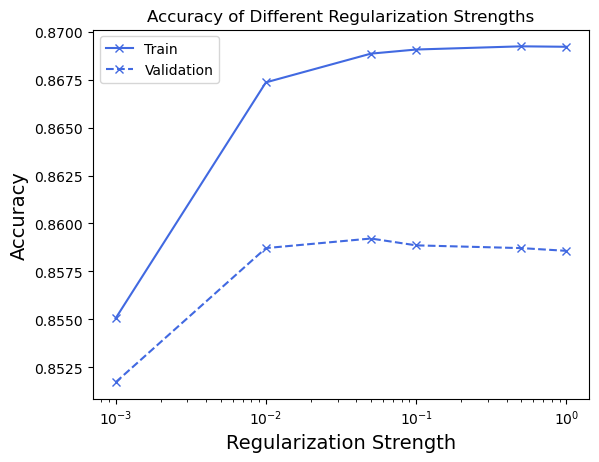

In [24]:
graph = line_graph(strengths, train_results, val_results, 'Accuracy of Different Regularization Strengths', 
                   'Regularization Strength', 'Accuracy', 'royalblue', 'upper left')
graph.show()

In [25]:
### Combine the best hyperparameters so far to predict the test dataset

classifier = LogisticRegression(solver='sag', penalty='l2', fit_intercept=True, 
                                C=0.05, random_state=seed).fit(X_tr, y_tr)
predict_test = classifier.predict(X_te)
accuracy = accuracy_score(y_te, predict_test)

print(f"Final Accuracy for Testing Data: {accuracy}")

Final Accuracy for Testing Data: 0.853


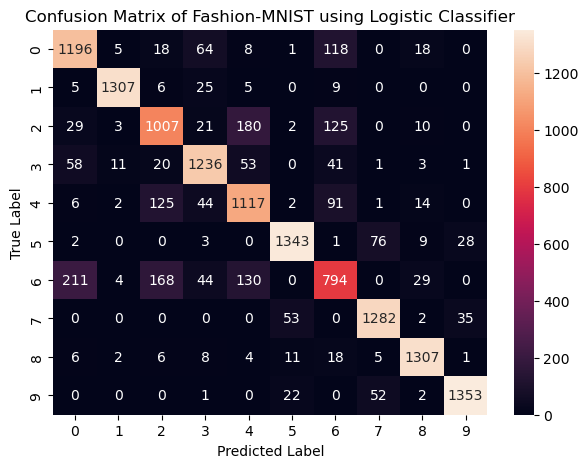

In [26]:
cm_lc = cm(predict_test, "Logistic Classifier")
cm_lc.show()

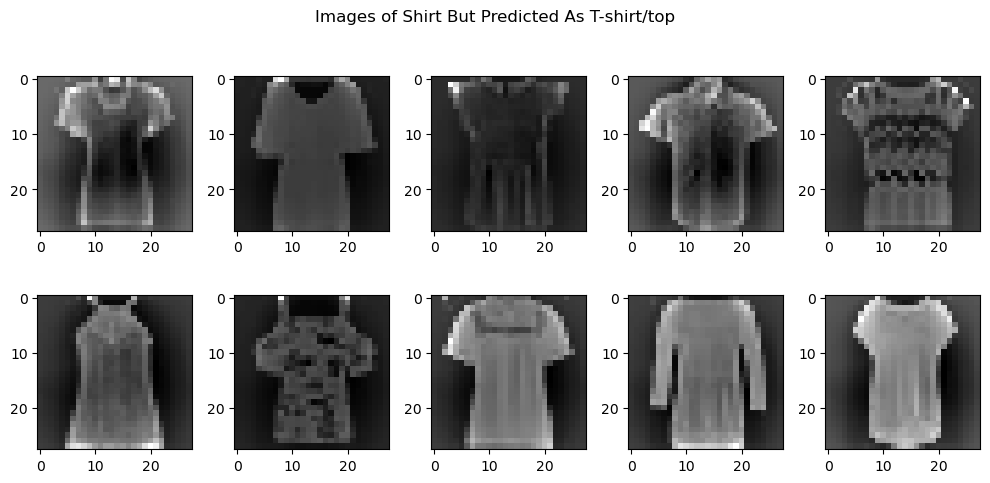

In [27]:
wrong_predictions = print_incorrect(predict_test, 6, 0)
wrong_predictions.show()

### Neural Network

In [43]:
DEFAULTS_NN = {"Hidden Layers": (100), "Activation": 'relu', "Solver": "adam", "Learning Rate": 0.001,
           "Batch Size": 'auto', "Regularization Strength": 0.0001, "Train Accuracy": 0, "Validation Accuracy": 0}
HEADERS_NN = ["Hidden Layers", "Activation", "Solver", "Learning Rate", "Batch Size",
           "Regularization Strength", "Train Accuracy", "Validation Accuracy"]

In [44]:
def neural_network(settings, hidden=(100), activation='relu', solver='adam', 
                   learning_rate=0.001, batch='auto', r_strength=0.0001):
    neural_network = MLPClassifier(hidden_layer_sizes=hidden, activation=activation, solver=solver,
                                  alpha=r_strength, batch_size=batch, learning_rate_init=learning_rate,
                                  random_state=seed).fit(X_tr, y_tr)
    
    predict_tr = neural_network.predict(X_tr)
    predict_val = neural_network.predict(X_val)
    
    accuracy_tr = accuracy_score(y_tr, predict_tr)
    accuracy_val = accuracy_score(y_val, predict_val)
    
    settings["Hidden Layers"] = hidden
    settings["Activation"] = activation
    settings["Solver"] = solver
    settings["Learning Rate"] = learning_rate
    settings["Batch Size"] = batch
    settings["Regularization Strength"] = r_strength
    settings["Train Accuracy"] = accuracy_tr
    settings["Validation Accuracy"] = accuracy_val
    
    print(settings)
    
    return settings

In [45]:
## test with default settings
file_nn = './results/neural_network.csv'

default_predict = neural_network(DEFAULTS_NN.copy())
write_results(file_nn, default_predict, HEADERS_NN)



{'Hidden Layers': 100, 'Activation': 'relu', 'Solver': 'adam', 'Learning Rate': 0.001, 'Batch Size': 'auto', 'Regularization Strength': 0.0001, 'Train Accuracy': 0.9968333333333333, 'Validation Accuracy': 0.8796428571428572}


In [46]:
## Test for best solver

lbfgs = neural_network(DEFAULTS_NN.copy(), solver='lbfgs')
write_results(file_nn, lbfgs, HEADERS_NN)

sgd = neural_network(DEFAULTS_NN.copy(), solver='sgd')
write_results(file_nn, sgd, HEADERS_NN)

{'Hidden Layers': 100, 'Activation': 'relu', 'Solver': 'lbfgs', 'Learning Rate': 0.001, 'Batch Size': 'auto', 'Regularization Strength': 0.0001, 'Train Accuracy': 0.9840714285714286, 'Validation Accuracy': 0.878}
{'Hidden Layers': 100, 'Activation': 'relu', 'Solver': 'sgd', 'Learning Rate': 0.001, 'Batch Size': 'auto', 'Regularization Strength': 0.0001, 'Train Accuracy': 0.962452380952381, 'Validation Accuracy': 0.8889285714285714}


In [47]:
## Test for best regularization strength

strengths = [0.001, 0.01, 0.05, 0.1, 0.5, 1]

for elem in strengths:
    nn = neural_network(DEFAULTS_NN.copy(), solver='sgd', r_strength=elem)
    write_results(file_nn, nn, HEADERS_NN)

{'Hidden Layers': 100, 'Activation': 'relu', 'Solver': 'sgd', 'Learning Rate': 0.001, 'Batch Size': 'auto', 'Regularization Strength': 0.001, 'Train Accuracy': 0.9625238095238096, 'Validation Accuracy': 0.8883571428571428}
{'Hidden Layers': 100, 'Activation': 'relu', 'Solver': 'sgd', 'Learning Rate': 0.001, 'Batch Size': 'auto', 'Regularization Strength': 0.01, 'Train Accuracy': 0.9621666666666666, 'Validation Accuracy': 0.8896428571428572}
{'Hidden Layers': 100, 'Activation': 'relu', 'Solver': 'sgd', 'Learning Rate': 0.001, 'Batch Size': 'auto', 'Regularization Strength': 0.05, 'Train Accuracy': 0.9607857142857142, 'Validation Accuracy': 0.8883571428571428}
{'Hidden Layers': 100, 'Activation': 'relu', 'Solver': 'sgd', 'Learning Rate': 0.001, 'Batch Size': 'auto', 'Regularization Strength': 0.1, 'Train Accuracy': 0.9582857142857143, 'Validation Accuracy': 0.8895714285714286}
{'Hidden Layers': 100, 'Activation': 'relu', 'Solver': 'sgd', 'Learning Rate': 0.001, 'Batch Size': 'auto', 'Reg

In [52]:
## Test for best learning rate

learning_rates = [0.01, 0.05, 0.1]

for elem in learning_rates:
    nn = neural_network(DEFAULTS_NN.copy(), solver='sgd', r_strength=0.5,learning_rate=elem)
    write_results(file_nn, nn, HEADERS_NN)

{'Hidden Layers': 100, 'Activation': 'relu', 'Solver': 'sgd', 'Learning Rate': 0.01, 'Batch Size': 'auto', 'Regularization Strength': 0.5, 'Train Accuracy': 0.9563333333333334, 'Validation Accuracy': 0.8977142857142857}
{'Hidden Layers': 100, 'Activation': 'relu', 'Solver': 'sgd', 'Learning Rate': 0.05, 'Batch Size': 'auto', 'Regularization Strength': 0.5, 'Train Accuracy': 0.9149761904761905, 'Validation Accuracy': 0.8757857142857143}
{'Hidden Layers': 100, 'Activation': 'relu', 'Solver': 'sgd', 'Learning Rate': 0.1, 'Batch Size': 'auto', 'Regularization Strength': 0.5, 'Train Accuracy': 0.9008095238095238, 'Validation Accuracy': 0.8777142857142857}


In [55]:
## Testing for Hidden Layers 

#layers = [(100, 200), (100, 200, 250), (50, 100, 150, 200), (200, 300, 400)]
#layers = [(50), (70), (50, 100)]
layers = [(150), (200)]

for elem in layers:
    nn = neural_network(DEFAULTS_NN.copy(), hidden=elem,solver='sgd', r_strength=0.5, learning_rate=0.01)
    write_results(file_nn, nn, HEADERS_NN)

{'Hidden Layers': 150, 'Activation': 'relu', 'Solver': 'sgd', 'Learning Rate': 0.01, 'Batch Size': 'auto', 'Regularization Strength': 0.5, 'Train Accuracy': 0.9606666666666667, 'Validation Accuracy': 0.8957857142857143}
{'Hidden Layers': 200, 'Activation': 'relu', 'Solver': 'sgd', 'Learning Rate': 0.01, 'Batch Size': 'auto', 'Regularization Strength': 0.5, 'Train Accuracy': 0.9626904761904762, 'Validation Accuracy': 0.8967142857142857}


In [58]:
## test batch size

batch_sizes = [100, 200, 250, 300]

for elem in batch_sizes:
    nn = neural_network(DEFAULTS_NN.copy(),solver='sgd', r_strength=0.5, learning_rate=0.01, batch=elem)
    write_results(file_nn, nn, HEADERS_NN)

{'Hidden Layers': 100, 'Activation': 'relu', 'Solver': 'sgd', 'Learning Rate': 0.01, 'Batch Size': 100, 'Regularization Strength': 0.5, 'Train Accuracy': 0.9115952380952381, 'Validation Accuracy': 0.8865714285714286}
{'Hidden Layers': 100, 'Activation': 'relu', 'Solver': 'sgd', 'Learning Rate': 0.01, 'Batch Size': 200, 'Regularization Strength': 0.5, 'Train Accuracy': 0.9563333333333334, 'Validation Accuracy': 0.8977142857142857}
{'Hidden Layers': 100, 'Activation': 'relu', 'Solver': 'sgd', 'Learning Rate': 0.01, 'Batch Size': 250, 'Regularization Strength': 0.5, 'Train Accuracy': 0.9715238095238096, 'Validation Accuracy': 0.8952857142857142}
{'Hidden Layers': 100, 'Activation': 'relu', 'Solver': 'sgd', 'Learning Rate': 0.01, 'Batch Size': 300, 'Regularization Strength': 0.5, 'Train Accuracy': 0.9779047619047619, 'Validation Accuracy': 0.8939285714285714}


In [60]:
# test activation

activations = ["identity", 'logistic', 'tanh']

for elem in activations:
    nn = neural_network(DEFAULTS_NN.copy(),solver='sgd', r_strength=0.5, learning_rate=0.01, activation=elem)
    write_results(file_nn, nn, HEADERS_NN)

{'Hidden Layers': 100, 'Activation': 'identity', 'Solver': 'sgd', 'Learning Rate': 0.01, 'Batch Size': 'auto', 'Regularization Strength': 0.5, 'Train Accuracy': 0.8728809523809524, 'Validation Accuracy': 0.8571428571428571}
{'Hidden Layers': 100, 'Activation': 'logistic', 'Solver': 'sgd', 'Learning Rate': 0.01, 'Batch Size': 'auto', 'Regularization Strength': 0.5, 'Train Accuracy': 0.8861428571428571, 'Validation Accuracy': 0.8748571428571429}
{'Hidden Layers': 100, 'Activation': 'tanh', 'Solver': 'sgd', 'Learning Rate': 0.01, 'Batch Size': 'auto', 'Regularization Strength': 0.5, 'Train Accuracy': 0.9491666666666667, 'Validation Accuracy': 0.8918571428571429}


In [61]:
df = view_results(file_nn)
df

,Hidden Layers,Activation,Solver,Learning Rate,Batch Size,Regularization Strength,Train Accuracy,Validation Accuracy
0,100,relu,adam,0.001,auto,0.0001,0.996833,0.879643
1,100,relu,lbfgs,0.001,auto,0.0001,0.984071,0.878000
2,100,relu,sgd,0.001,auto,0.0001,0.962452,0.888929
3,100,relu,sgd,0.001,auto,0.0010,0.962524,0.888357
4,100,relu,sgd,0.001,auto,0.0100,0.962167,0.889643
5,100,relu,sgd,0.001,auto,0.0500,0.960786,0.888357
6,100,relu,sgd,0.001,auto,0.1000,0.958286,0.889571
7,100,relu,sgd,0.001,auto,0.5000,0.939190,0.891357
8,100,relu,sgd,0.001,auto,1.0000,0.919762,0.889500
9,100,relu,sgd,0.010,auto,0.5000,0.956333,0.897714


In [62]:
# Make prediction on testing set based on best settings

neural_network = MLPClassifier(hidden_layer_sizes=100, activation='relu', solver='sgd',
                              alpha=0.5, batch_size='auto', learning_rate_init=0.01,
                              random_state=seed).fit(X_tr, y_tr)

predict_test = neural_network.predict(X_te)
accuracy_test = accuracy_score(y_te, predict_test)

print(f"Testing Accuracy Using Neural Network: {accuracy_test}")

Testing Accuracy Using Neural Network: 0.8922142857142857


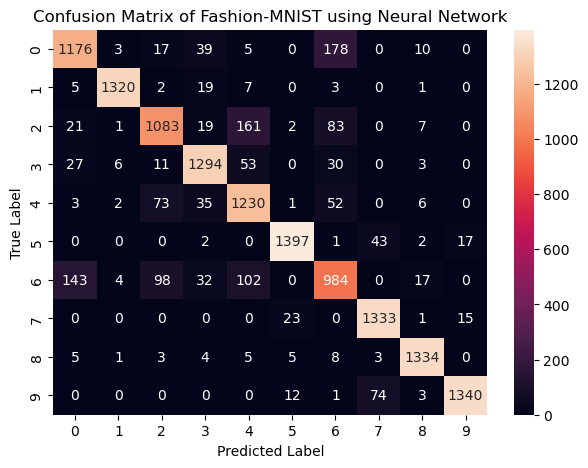

In [63]:
cm_nn = cm(predict_test, "Neural Network")
cm_nn.show()

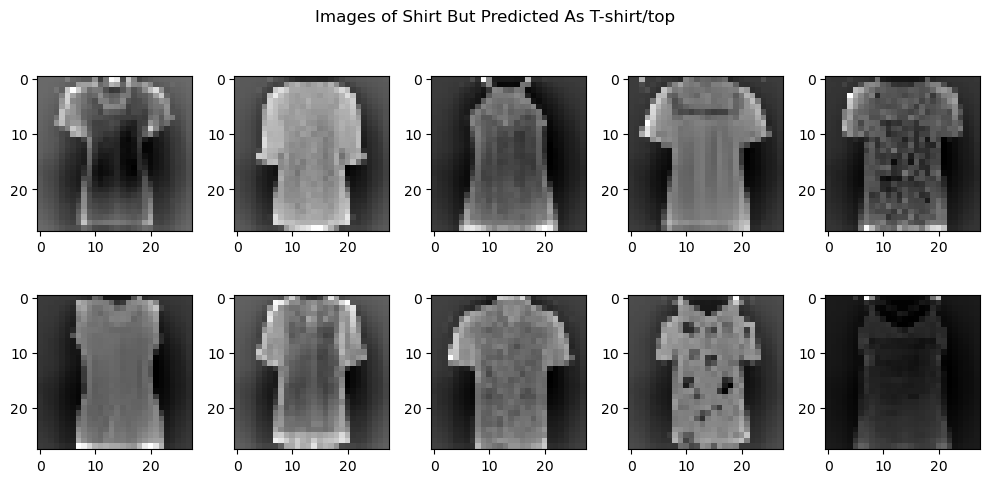

In [64]:
wrong_predictions = print_incorrect(predict_test, 6, 0)
wrong_predictions.show()

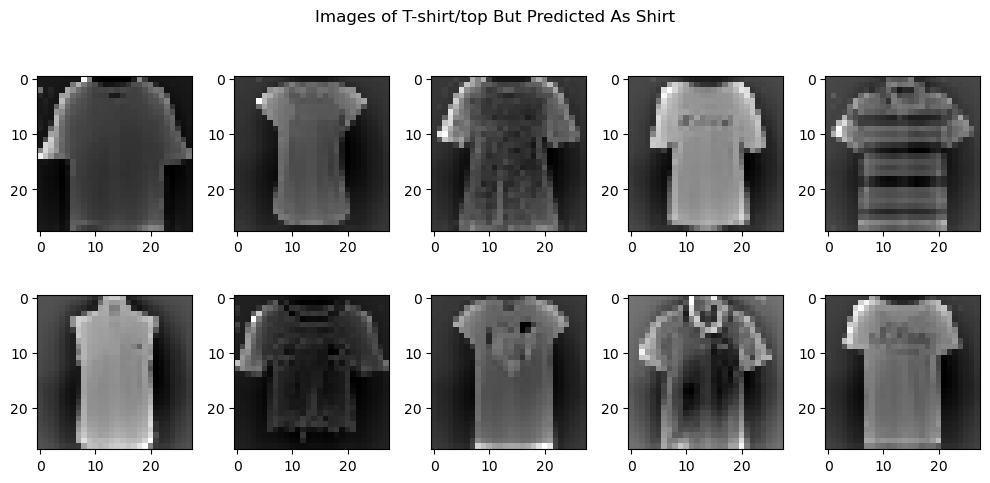

In [65]:
wrong_predictions = print_incorrect(predict_test, 0, 6)
wrong_predictions.show()

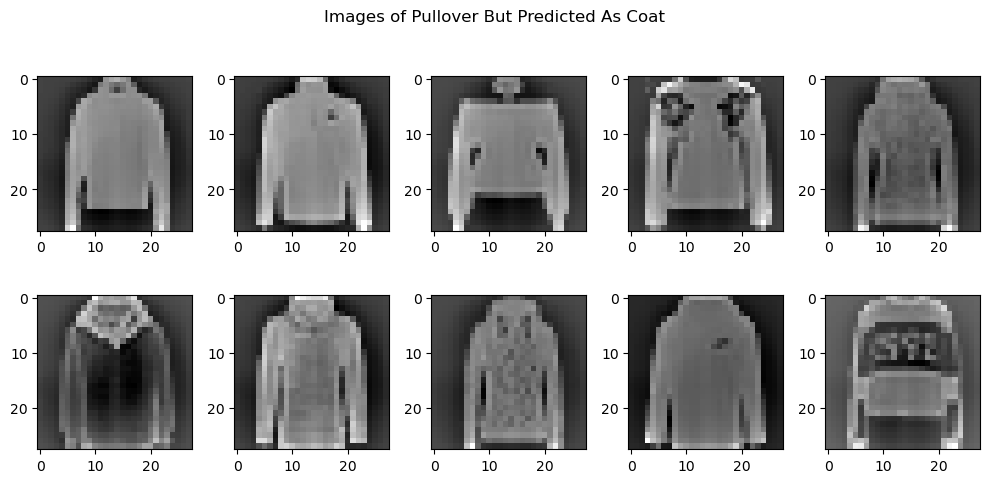

In [66]:
wrong_predictions = print_incorrect(predict_test, 2, 4)
wrong_predictions.show()

### Random Forest

In [9]:
DEFAULTS_RF = {"Number of Trees": 100, "Criterion": "gini", "Max Depth": None, "Min Sample Split": 2,
              "Min Sample Leaf": 1, "Max Features": "sqrt", "Train Accuracy": 0, "Validation Accuracy": 0}

HEADERS_RF = ["Number of Trees", "Criterion", "Max Depth", "Min Sample Split", "Min Sample Leaf", "Max Features",
             "Train Accuracy", "Validation Accuracy"]

In [10]:
def random_forest(settings, estimators=100, criterion='gini', depth=None, split=2, leaf=1, feature='sqrt'):
    
    random_forest = RandomForestClassifier(n_estimators=estimators, criterion=criterion, max_depth=depth,
                                         min_samples_split=split, min_samples_leaf=leaf, random_state=seed)
    random_forest.fit(X_tr, y_tr)
    
    predict_tr = random_forest.predict(X_tr)
    predict_val = random_forest.predict(X_val)
    
    settings["Number of Trees"] = estimators
    settings["Criterion"] = criterion
    settings["Max Depth"] = depth
    settings["Min Sample Split"] = split
    settings["Min Sample Leaf"] = leaf
    settings["Max Features"] = feature
    settings["Train Accuracy"] = accuracy_score(y_tr, predict_tr)
    settings["Validation Accuracy"] = accuracy_score(y_val, predict_val)

    print(settings)
    
    return settings

In [11]:
# test with default settings
file_rf = './results/random_forest.csv'

default_predict = random_forest(DEFAULTS_RF.copy())
write_results(file_rf, default_predict, HEADERS_RF)

{'Number of Trees': 100, 'Criterion': 'gini', 'Max Depth': None, 'Min Sample Split': 2, 'Min Sample Leaf': 1, 'Max Features': 'sqrt', 'Train Accuracy': 1.0, 'Validation Accuracy': 0.8823571428571428}


In [85]:
## test for best # trees

trees = [110, 120, 150, 200, 250, 300]
tr_accuracy, val_accuracy = [], []

for elem in trees:
    rf = random_forest(DEFAULTS_RF.copy(), estimators=elem)
    write_results(file_rf, rf, HEADERS_RF)
    tr_accuracy.append(rf['Train Accuracy'])
    val_accuracy.append(rf['Validation Accuracy'])

{'Number of Trees': 110, 'Criterion': 'gini', 'Max Depth': None, 'Min Sample Split': 2, 'Min Sample Leaf': 1, 'Max Features': 'sqrt', 'Train Accuracy': 1.0, 'Validation Accuracy': 0.882}
{'Number of Trees': 120, 'Criterion': 'gini', 'Max Depth': None, 'Min Sample Split': 2, 'Min Sample Leaf': 1, 'Max Features': 'sqrt', 'Train Accuracy': 1.0, 'Validation Accuracy': 0.8817857142857143}
{'Number of Trees': 150, 'Criterion': 'gini', 'Max Depth': None, 'Min Sample Split': 2, 'Min Sample Leaf': 1, 'Max Features': 'sqrt', 'Train Accuracy': 1.0, 'Validation Accuracy': 0.8831428571428571}
{'Number of Trees': 200, 'Criterion': 'gini', 'Max Depth': None, 'Min Sample Split': 2, 'Min Sample Leaf': 1, 'Max Features': 'sqrt', 'Train Accuracy': 1.0, 'Validation Accuracy': 0.8843571428571428}
{'Number of Trees': 250, 'Criterion': 'gini', 'Max Depth': None, 'Min Sample Split': 2, 'Min Sample Leaf': 1, 'Max Features': 'sqrt', 'Train Accuracy': 1.0, 'Validation Accuracy': 0.8846428571428572}
{'Number of T

In [86]:
## test criterion

criterions = ["entropy", "log_loss"]
for elem in criterions:
    rf = random_forest(DEFAULTS_RF.copy(), estimators=300, criterion=elem)
    write_results(file_rf, rf, HEADERS_RF)


{'Number of Trees': 300, 'Criterion': 'entropy', 'Max Depth': None, 'Min Sample Split': 2, 'Min Sample Leaf': 1, 'Max Features': 'sqrt', 'Train Accuracy': 1.0, 'Validation Accuracy': 0.8850714285714286}
{'Number of Trees': 300, 'Criterion': 'log_loss', 'Max Depth': None, 'Min Sample Split': 2, 'Min Sample Leaf': 1, 'Max Features': 'sqrt', 'Train Accuracy': 1.0, 'Validation Accuracy': 0.8850714285714286}


In [88]:
## Tuning Max depth

max_depths = [5, 8, 10, 15, 20, 25, 30, 35, 40]
tr_accuracy, val_accuracy = [], []

for elem in max_depths:
    rf = random_forest(DEFAULTS_RF.copy(), estimators=300, depth=elem)
    write_results(file_rf, rf, HEADERS_RF)
    tr_accuracy.append(rf['Train Accuracy'])
    val_accuracy.append(rf['Validation Accuracy'])

{'Number of Trees': 300, 'Criterion': 'gini', 'Max Depth': 5, 'Min Sample Split': 2, 'Min Sample Leaf': 1, 'Max Features': 'sqrt', 'Train Accuracy': 0.7723095238095238, 'Validation Accuracy': 0.7722857142857142}
{'Number of Trees': 300, 'Criterion': 'gini', 'Max Depth': 8, 'Min Sample Split': 2, 'Min Sample Leaf': 1, 'Max Features': 'sqrt', 'Train Accuracy': 0.8465, 'Validation Accuracy': 0.8387857142857142}
{'Number of Trees': 300, 'Criterion': 'gini', 'Max Depth': 10, 'Min Sample Split': 2, 'Min Sample Leaf': 1, 'Max Features': 'sqrt', 'Train Accuracy': 0.8881190476190476, 'Validation Accuracy': 0.8575714285714285}
{'Number of Trees': 300, 'Criterion': 'gini', 'Max Depth': 15, 'Min Sample Split': 2, 'Min Sample Leaf': 1, 'Max Features': 'sqrt', 'Train Accuracy': 0.9723095238095238, 'Validation Accuracy': 0.8775714285714286}
{'Number of Trees': 300, 'Criterion': 'gini', 'Max Depth': 20, 'Min Sample Split': 2, 'Min Sample Leaf': 1, 'Max Features': 'sqrt', 'Train Accuracy': 0.9952619047

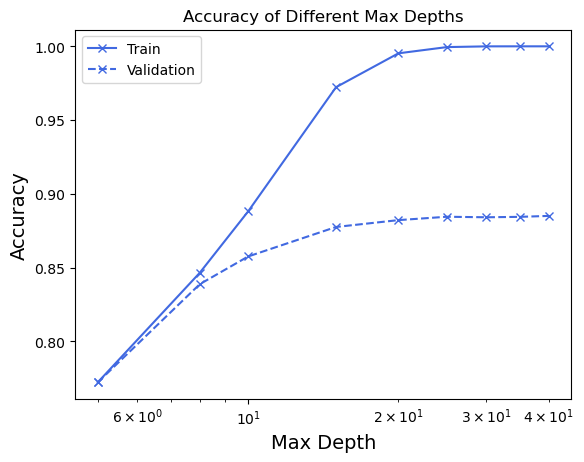

In [89]:
graph = line_graph(max_depths, tr_accuracy, val_accuracy, 'Accuracy of Different Max Depths', 
                   'Max Depth', 'Accuracy', 'royalblue', 'upper left')
graph.show()

In [15]:
# test min sample split

splits = [3, 4, 5, 6, 10, 15, 20]

tr_accuracy, val_accuracy = [], []

for elem in splits:
    rf = random_forest(DEFAULTS_RF.copy(), estimators=300, depth=25, split=elem)
    write_results(file_rf, rf, HEADERS_RF)
    tr_accuracy.append(rf['Train Accuracy'])
    val_accuracy.append(rf['Validation Accuracy'])
    

{'Number of Trees': 300, 'Criterion': 'gini', 'Max Depth': 25, 'Min Sample Split': 3, 'Min Sample Leaf': 1, 'Max Features': 'sqrt', 'Train Accuracy': 0.9991904761904762, 'Validation Accuracy': 0.8855}
{'Number of Trees': 300, 'Criterion': 'gini', 'Max Depth': 25, 'Min Sample Split': 4, 'Min Sample Leaf': 1, 'Max Features': 'sqrt', 'Train Accuracy': 0.998547619047619, 'Validation Accuracy': 0.8844285714285715}
{'Number of Trees': 300, 'Criterion': 'gini', 'Max Depth': 25, 'Min Sample Split': 5, 'Min Sample Leaf': 1, 'Max Features': 'sqrt', 'Train Accuracy': 0.9978095238095238, 'Validation Accuracy': 0.8837142857142857}
{'Number of Trees': 300, 'Criterion': 'gini', 'Max Depth': 25, 'Min Sample Split': 6, 'Min Sample Leaf': 1, 'Max Features': 'sqrt', 'Train Accuracy': 0.9965238095238095, 'Validation Accuracy': 0.8832857142857143}
{'Number of Trees': 300, 'Criterion': 'gini', 'Max Depth': 25, 'Min Sample Split': 10, 'Min Sample Leaf': 1, 'Max Features': 'sqrt', 'Train Accuracy': 0.99052380

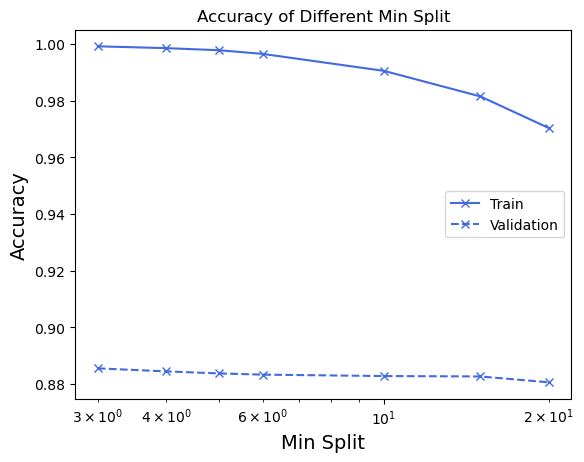

In [19]:
graph = line_graph(splits, tr_accuracy, val_accuracy, 'Accuracy of Different Min Split', 
                   'Min Split', 'Accuracy', 'royalblue', 'center right')
graph.show()

In [24]:
# test min sample leaf

leaf = [2, 3, 4, 5, 6, 10, 15, 20]

tr_accuracy, val_accuracy = [], []

for elem in leaf:
    rf = random_forest(DEFAULTS_RF.copy(), estimators=300, depth=25, split=3, leaf=elem)
    write_results(file_rf, rf, HEADERS_RF)
    tr_accuracy.append(rf['Train Accuracy'])
    val_accuracy.append(rf['Validation Accuracy'])
    

{'Number of Trees': 300, 'Criterion': 'gini', 'Max Depth': 25, 'Min Sample Split': 3, 'Min Sample Leaf': 2, 'Max Features': 'sqrt', 'Train Accuracy': 0.996452380952381, 'Validation Accuracy': 0.883}
{'Number of Trees': 300, 'Criterion': 'gini', 'Max Depth': 25, 'Min Sample Split': 3, 'Min Sample Leaf': 3, 'Max Features': 'sqrt', 'Train Accuracy': 0.9886190476190476, 'Validation Accuracy': 0.8829285714285714}
{'Number of Trees': 300, 'Criterion': 'gini', 'Max Depth': 25, 'Min Sample Split': 3, 'Min Sample Leaf': 4, 'Max Features': 'sqrt', 'Train Accuracy': 0.9793095238095239, 'Validation Accuracy': 0.8823571428571428}
{'Number of Trees': 300, 'Criterion': 'gini', 'Max Depth': 25, 'Min Sample Split': 3, 'Min Sample Leaf': 5, 'Max Features': 'sqrt', 'Train Accuracy': 0.9695952380952381, 'Validation Accuracy': 0.8799285714285714}
{'Number of Trees': 300, 'Criterion': 'gini', 'Max Depth': 25, 'Min Sample Split': 3, 'Min Sample Leaf': 6, 'Max Features': 'sqrt', 'Train Accuracy': 0.9602142857

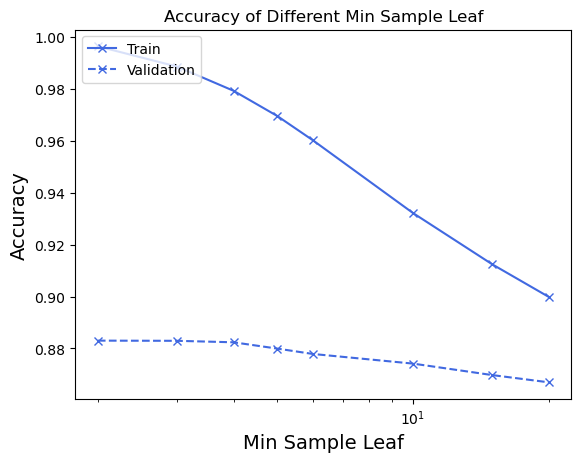

In [25]:
graph = line_graph(leaf, tr_accuracy, val_accuracy, 'Accuracy of Different Min Sample Leaf', 
                   'Min Sample Leaf', 'Accuracy', 'royalblue', 'upper left')
graph.show()

In [26]:
# tune max_features

features = [10, 15, 20, 30, 50, 100, "auto", "sqrt", "log2", None]

for elem in features:
    rf = random_forest(DEFAULTS_RF.copy(), estimators=300, depth=25, split=3, feature=elem)
    write_results(file_rf, rf, HEADERS_RF)
    tr_accuracy.append(rf['Train Accuracy'])
    val_accuracy.append(rf['Validation Accuracy'])

{'Number of Trees': 300, 'Criterion': 'gini', 'Max Depth': 25, 'Min Sample Split': 3, 'Min Sample Leaf': 1, 'Max Features': 10, 'Train Accuracy': 0.9991904761904762, 'Validation Accuracy': 0.8855}
{'Number of Trees': 300, 'Criterion': 'gini', 'Max Depth': 25, 'Min Sample Split': 3, 'Min Sample Leaf': 1, 'Max Features': 15, 'Train Accuracy': 0.9991904761904762, 'Validation Accuracy': 0.8855}
{'Number of Trees': 300, 'Criterion': 'gini', 'Max Depth': 25, 'Min Sample Split': 3, 'Min Sample Leaf': 1, 'Max Features': 20, 'Train Accuracy': 0.9991904761904762, 'Validation Accuracy': 0.8855}
{'Number of Trees': 300, 'Criterion': 'gini', 'Max Depth': 25, 'Min Sample Split': 3, 'Min Sample Leaf': 1, 'Max Features': 30, 'Train Accuracy': 0.9991904761904762, 'Validation Accuracy': 0.8855}
{'Number of Trees': 300, 'Criterion': 'gini', 'Max Depth': 25, 'Min Sample Split': 3, 'Min Sample Leaf': 1, 'Max Features': 50, 'Train Accuracy': 0.9991904761904762, 'Validation Accuracy': 0.8855}
{'Number of Tre

In [27]:
df = view_results(file_rf)
df

,Number of Trees,Criterion,Max Depth,Min Sample Split,Min Sample Leaf,Max Features,Train Accuracy,Validation Accuracy
0,100,gini,NaN,2,1,sqrt,1.000000,0.882357
1,110,gini,NaN,2,1,sqrt,1.000000,0.882000
2,120,gini,NaN,2,1,sqrt,1.000000,0.881786
3,150,gini,NaN,2,1,sqrt,1.000000,0.883143
4,200,gini,NaN,2,1,sqrt,1.000000,0.884357
5,250,gini,NaN,2,1,sqrt,1.000000,0.884643
6,300,gini,NaN,2,1,sqrt,1.000000,0.885500
7,300,entropy,NaN,2,1,sqrt,1.000000,0.885071
8,300,log_loss,NaN,2,1,sqrt,1.000000,0.885071
9,300,gini,5.0,2,1,sqrt,0.772310,0.772286
